# We use the dataset from https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

The main objective of this AutoEncoder notebook is to extract feature vectors from this flower dataset, then find the top K closest images to a testing image by comparing their feature vectors. We use cosine similarity to compare their feature vectors.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_folder = "/content/drive/MyDrive/hcmus lab/102flowers/jpg"
data_test = "/content/drive/MyDrive/hcmus lab/102flowers_test/jpg"

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# Preprocessing the images

In this block, we resize our image size (which is arbitrary large) down to 28 x 28 and divide each pixel by 255.0. Each pixel has a value between 0 and 255, which result in a very large value after each layer because we use ReLU activation function. Therefore, the division by 255.0 is a MUST!

In [ ]:
def get_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28,28))
    img_tensor = np.asarray(img) / 255.0
    return img_tensor

# Creating vectors containing training and test data

In [ ]:
import os

def make_vectors(data_folder):
  result = []
  for image_path in os.listdir(data_folder):
      # get full path
      image_path_full = os.path.join(data_folder, image_path)
      # preprocess the image 
      image_vector = get_image(image_path_full)
      # Add dac trung vao list
      result.append(image_vector)
  return result

In [ ]:
vectors_test = np.array(make_vectors(data_test))
vectors_train = np.array(make_vectors(data_folder))
print(vectors_train.shape)
print(vectors_test.shape)

(8199, 28, 28, 3)
(770, 28, 28, 3)


# Creating the AutoEncoder model

The first block of code is the AutoEncoder model with convolutional layers.

In [ ]:
''' 
input_shape = (28,28,3)
target_vector = 28* 28 * 3

encoder_input = keras.Input(shape=input_shape, name = 'img')
x = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Flatten()(x)
dense1 = keras.layers.Dense(7*7*64, activation="relu")(x)
dropout = keras.layers.Dropout(0.4)(dense1)

encoder = keras.Model(encoder_input, x, name="encoder")

reshape = keras.layers.Reshape((7,7,64))(dense1)
x = keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(reshape)
x = layers.UpSampling2D((2, 2))(x)

x = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_output = keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

opt = keras.optimizers.Adam(lr=0.001, decay = 1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name = "autoencoder")
autoencoder.summary()

autoencoder.compile(opt, loss="mse")
'''

This is the Autoencoder model with dense layers.

In [ ]:
input_shape = (28,28,3)
target_vector = 28**2 * 3

encoder_input = keras.Input(shape=input_shape, name = 'img')
flatten = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(784, activation="relu")(flatten)
encoder_dropout = keras.layers.Dropout(0.2)(encoder_output)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")

dense2 = keras.layers.Dense(target_vector, activation="relu")(encoder_dropout)
decoder_output = keras.layers.Reshape(input_shape)(dense2)

opt = keras.optimizers.Adam(lr=0.001, decay = 1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name = "autoencoder")
autoencoder.summary()

autoencoder.compile(opt, loss="mse")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 3)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 2352)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               1844752   
                                                                 
 dropout_1 (Dropout)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 2352)              1846320   
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 3)         0         
                                                                 
Total params: 3,691,072
Trainable params: 3,691,072
Non

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train model

In [ ]:
autoencoder.fit(vectors_train, vectors_train, shuffle=True, batch_size=128, epochs=50, validation_split = 0.1)


Epoch 1/50
58/58 [==============================] - 6s 105ms/step - loss: 0.0619 - val_loss: 0.0384
Epoch 2/50
58/58 [==============================] - 5s 87ms/step - loss: 0.0345 - val_loss: 0.0286
Epoch 3/50
58/58 [==============================] - 4s 71ms/step - loss: 0.0293 - val_loss: 0.0253
Epoch 4/50
58/58 [==============================] - 4s 72ms/step - loss: 0.0267 - val_loss: 0.0233
Epoch 5/50
58/58 [==============================] - 4s 71ms/step - loss: 0.0250 - val_loss: 0.0224
Epoch 6/50
58/58 [==============================] - 4s 71ms/step - loss: 0.0239 - val_loss: 0.0218
Epoch 7/50
58/58 [==============================] - 4s 72ms/step - loss: 0.0229 - val_loss: 0.0198
Epoch 8/50
58/58 [==============================] - 4s 72ms/step - loss: 0.0220 - val_loss: 0.0204
Epoch 9/50
58/58 [==============================] - 4s 72ms/step - loss: 0.0215 - val_loss: 0.0186
Epoch 10/50
58/58 [==============================] - 4s 72ms/step - loss: 0.0209 - val_loss: 0.0180
Epoch 11

# Run Autoencoder on an image

1/1 [==============================] - 0s 65ms/step
(28, 28, 3)


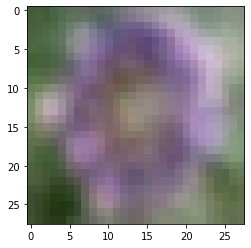

In [ ]:
x = autoencoder.predict([vectors_test[10].reshape(-1,28,28,3)])[0]
print(x.shape)
plt.imshow(x)


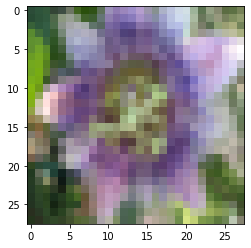

In [ ]:
plt.imshow(vectors_test[10])

# Computing the closeness by cosine similarity

In [ ]:
search_vector = encoder.predict([vectors_test[10].reshape(-1,28,28,3)])[0]

vectors_after_encoder = encoder.predict(vectors_train, batch_size=128)
cos_simi = []
K = 16
for i, vector in enumerate(vectors_after_encoder):
  cosine = np.dot(search_vector,vector)/(np.linalg.norm(vector)*np.linalg.norm(search_vector))
  cos_simi.append([cosine, i])
#print(cos_simi)
cos_simi.sort(key = lambda x : x[0], reverse=True)
cos_simi = cos_simi[:K]



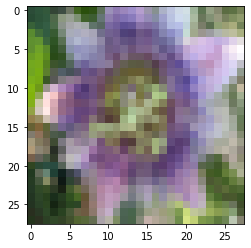

In [ ]:
plt.imshow(vectors_test[10])

# Print the top K closest image and their cosine similarity value (1 means most similar, 0 is opposite)

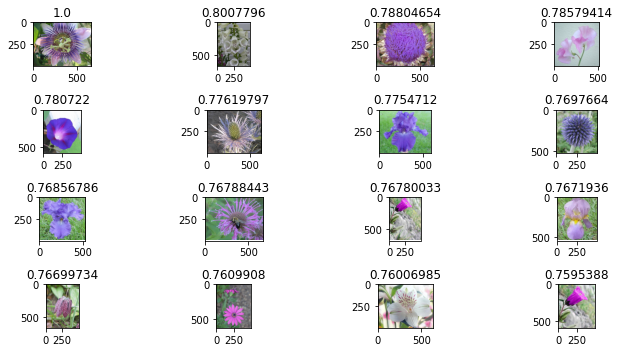

In [ ]:
axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(10,5))



for id in range(K):
    draw_image = os.path.join(data_folder, os.listdir(data_folder)[cos_simi[id][1]])
    axes.append(fig.add_subplot(grid_size, grid_size, id+1))

    axes[-1].set_title(cos_simi[id][0])
    plt.imshow(Image.open(draw_image))

fig.tight_layout()
